In [1]:
import numpy as np
import pandas as pd
import torch
from plotnine import *

/opt/conda/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Download yeast native promoter expression data

In [2]:
yeast_data = pd.read_csv(
    'https://zenodo.org/records/4436477/files/Native_complex.csv', usecols=(0, 1, 2),
    skiprows=1,
    index_col=0,
    names=['index', 'Sequence', 'expression'])

yeast_data.head()

,Sequence,expression
index,,
0,TGCATTTTTTTCACATCAAAAAAAAAAAGAAAAACAAAGAAAAAGG...,13.168816
1,TGCATTTTTTTCACATCAAAAAAAAAAAGAAAAAGAAACAAAAAGG...,13.457919
2,TGCATTTTTTTCACATCAAAAAAAAAAAGAAAAAGAAAGAAAAAGA...,13.855758
3,TGCATTTTTTTCACATCAAAAAAAAAAAGAAAAAGAAAGAAAAAGG...,12.043120
4,TGCATTTTTTTCACATCAAAAAAAAAAAGAAAAAGAAAGAAAAAGG...,13.529583


## Bin the sequences and create labels

In [3]:
import reglm.utils
yeast_data = reglm.utils.tokenize(yeast_data, cols=['expression'],
                             names=['expression'], n_bins=2)

yeast_data.head()

expression [9.24094738948754]


,Sequence,expression,label,expression_token
index,,,,
0,TGCATTTTTTTCACATCAAAAAAAAAAAGAAAAACAAAGAAAAAGG...,13.168816,1,1
1,TGCATTTTTTTCACATCAAAAAAAAAAAGAAAAAGAAACAAAAAGG...,13.457919,1,1
2,TGCATTTTTTTCACATCAAAAAAAAAAAGAAAAAGAAAGAAAAAGA...,13.855758,1,1
3,TGCATTTTTTTCACATCAAAAAAAAAAAGAAAAAGAAAGAAAAAGG...,12.043120,1,1
4,TGCATTTTTTTCACATCAAAAAAAAAAAGAAAAAGAAAGAAAAAGG...,13.529583,1,1


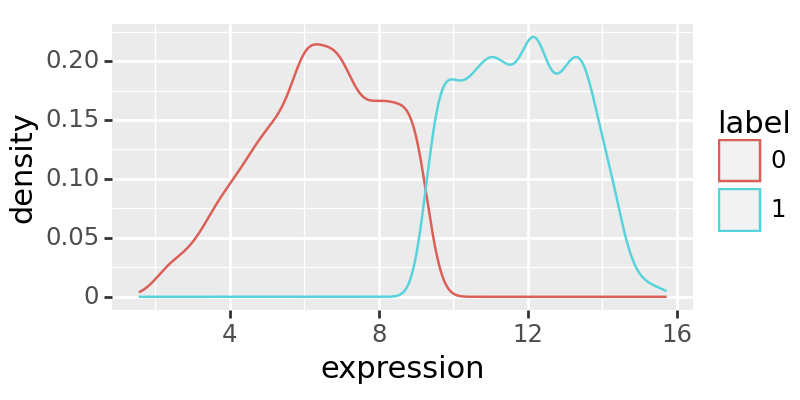

<Figure Size: (400 x 200)>

In [4]:
(
    ggplot(yeast_data, aes(x='expression', color='label')) + geom_density()
    + theme(figure_size=(4,2))
)

## Split data into train, val and test

In [5]:
rng = np.random.RandomState(0)
train = yeast_data[['Sequence', 'label']].copy()

val = train.sample(500, random_state=rng)
train = train.loc[~train.index.isin(val.index)]

test = train.sample(500, random_state=rng)
train = train.loc[~train.index.isin(test.index)]

len(train), len(val), len(test)

(2929, 500, 500)

## Create torch datasets for training and validation

In [6]:
import reglm.dataset
train_ds = reglm.dataset.CharDataset(
    train.Sequence.tolist(), labels = train.label.tolist())
val_ds = reglm.dataset.CharDataset(
    seqs = val.Sequence.tolist(), labels = val.label.tolist())

## Build the regLM model

In [7]:
import reglm.lightning

In [10]:
config = {
 'd_model': 32,
 'n_layer': 2,
 'd_inner': 32,
 'vocab_size': 12,
 'pad_vocab_size_multiple': 8,
 'return_hidden_state': True,
 'layer': {
     'emb_dim': 5,
     'filter_order': 64,
     'l_max': train_ds.seq_len + train_ds.label_len + 1,
     '_name_': 'hyena'
 }
}

In [12]:
model = reglm.lightning.LightningModel(
    config=config, lr=1e-3, label_len=1).to(torch.device(0))

number of parameters: 0.04M


## Train and validate model

In [13]:
trainer = model.train_on_dataset(train_ds, val_ds, max_epochs=10,
            batch_size=256, num_workers=8, device=0, val_check_interval=10
        )

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Validation DataLoader 0: 100%|██████████████████████████████████████| 2/2 [00:00<00:00,  2.59it/s]
Val loss: 2.639369010925293, val acc: 0.3059999942779541
Validation DataLoader 0: 100%|██████████████████████████████████████| 2/2 [00:00<00:00,  2.56it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.3059999942779541     │
│         val_loss          │    2.6393609046936035     │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]

  | Name      | Type               | Params
-------------------------------------------------
0 | model     | ConvLMHeadModel    | 37.1 K
1 | train_acc | MulticlassAccuracy | 0     
2 | val_acc   | MulticlassAccuracy | 0     
-------------------------------------------------
37.1 K    Trainable params
0         Non-trainable params
37.1 K    Total params
0.148     Total estimated model params size (MB)


Sanity Checking DataLoader 0: 100%|█████████████████████████████████| 2/2 [00:00<00:00, 60.27it/s]
Val loss: 2.639369010925293, val acc: 0.3059999942779541
                                                                                                  

/opt/conda/lib/python3.8/site-packages/pytorch_lightning/trainer/trainer.py:1595: PossibleUserWarning: The number of training batches (12) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 0:  71%|█████▋  | 10/14 [00:02<00:01,  3.79it/s, loss=2.41, v_num=10, train_loss_step=2.230]
Validation: 0it [00:00, ?it/s]
Epoch 0:  86%|██████▊ | 12/14 [00:04<00:00,  2.64it/s, loss=2.41, v_num=10, train_loss_step=2.230]
Val loss: 2.1948914527893066, val acc: 0.31873273849487305
Epoch 0:  86%|██████▊ | 12/14 [00:04<00:00,  2.64it/s, loss=2.41, v_num=10, train_loss_step=2.230]
Epoch 1:  71%|▋| 10/14 [00:02<00:01,  3.96it/s, loss=2.16, v_num=10, train_loss_step=1.870, train_
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                                              | 0/2 [00:00<?, ?it/s]
Epoch 1:  79%|▊| 11/14 [00:04<00:01,  2.38it/s, loss=2.16, v_num=10, train_loss_step=1.870, train_
Epoch 1:  86%|▊| 12/14 [00:04<00:00,  2.60it/s, loss=2.16, v_num=10, train_loss_step=1.870, train_
Val loss: 1.8451852798461914, val acc: 0.3271621763706207
Epoch 1:  86%|▊| 12/14 [00:04<00:00,  2.59it/s, loss=2.16, v_num=10, train_loss_step=1.870, train_
Epoch 2:  71%|▋| 10/14 [00:02

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|█| 14/14 [00:04<00:00,  3.11it/s, loss=1.27, v_num=10, train_loss_step=1.240, train_


In [14]:
trainer.checkpoint_callback.best_model_path

'./lightning_logs/version_10/checkpoints/epoch=9-step=118.ckpt'

## Load best validation model

In [15]:
model = reglm.lightning.LightningModel.load_from_checkpoint(
    trainer.checkpoint_callback.best_model_path)

model = model.to(torch.device(0))

number of parameters: 0.04M


## Compute accuracy on the test set

In [16]:
import reglm.metrics
test = reglm.metrics.compute_accuracy(model, test)

Mean accuracy: 0.481


In [17]:
test.head(3)

,Sequence,label,acc,acc_mean
index,,,,
1119,TGCATTTTTTTCACATCATTTTCATAACCATTTACCCTCATAAATG...,0,"[True, True, True, True, True, True, True, Tru...",0.567568
1814,TGCATTTTTTTCACATCCTAATTGTGACATAGGAACGAAAATTAAT...,0,"[True, True, True, True, True, True, True, Tru...",0.468468
1539,TGCATTTTTTTCACATCCCTGCGTGCCCGCGCACCCTGGCGACTTC...,1,"[True, True, True, True, True, True, True, Tru...",0.405405


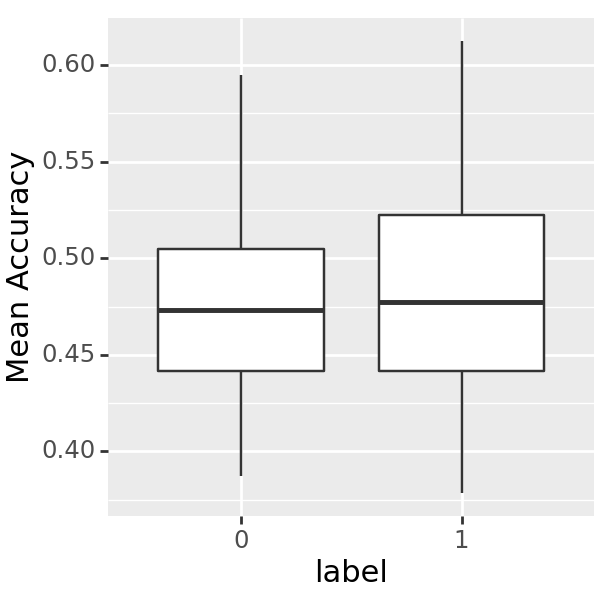

<Figure Size: (300 x 300)>

In [18]:
(
    ggplot(test, aes(x='label', y='acc_mean')) + geom_boxplot()
    + theme(figure_size=(3, 3)) + ylab('Mean Accuracy')
)

## Generate new sequences

In [19]:
prompts = ["0", "1"]

In [21]:
model.generate(prompts, max_new_tokens=110, top_k=2)

['TGCTATATTTTTTCACATCAACTACATAATAATAAATTTTAATAAAAAAATTAAGAAATATATATAATATATAAGGTATGGTTAATGTTTACGATTATTTATGTTTTCTT',
 'AGATATAATTTTAACATAACAAAATAAAAAAATTTAAGGTAAAATATATTTTTTAAAATAAATAAAAAATTTTAAATAAATAAAAATAATAAAAATTATAAAATTAAAGG']